# Page rank

## Imports

In [43]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

import networkx as nx
import graphviz as gv

## Network classes

In [44]:
class Page:
    """A class representing a webpage."""
    def __init__(self, name):
        """Constructor method, takes the name of the webpage as an argument."""
        self.name = name
        self.linksTo = []
        self.linksFrom = []
        
    def __repr__(self):
        """A page is represented by its name."""
        return self.name
    
    def addLinkFrom(self, other):
        """Adds a link from another page, ending at this page"""
        self.linksFrom.append(other)
    
    def addLinkTo(self, other):
        """Adds a link to another page, starting from this page"""
        self.linksTo.append(other)
        other.addLinkFrom(self)
        
    def outDegree(self):
        """Returns the amount of links this page has to other pages, i.e. its out-degree"""
        return len(self.linksTo)
    
    def getName(self):
        return self.name

In [45]:
class Network:
    """A class representing a network of webpages"""
    def __init__(self):
        """A network starts without any pages."""
        self.pages = []
        self.counter = 0
        
        # Whether the dataframe is out of date
        self.old_df = True
    
    def __iter__(self):
        """Iterating over a network is the same as iterating over its pages."""
        return iter(self.pages)
        
    def addPage(self, page: Page):
        """Adds a page to the network"""
        # give the page an id (since the name of the webpage doesn't have to be unique)
        page.id = self.counter
        self.counter += 1
        self.pages.append(page)
        
        # Dataframe is out of date now
        self.old_df = True
        
    def addPages(self, *args):
        """Adds multiple pages to the network"""
        for page in args:
            self.addPage(page)
        
    def getPages(self):
        """Returns the pages in the network."""
        return self.pages
    
    def size(self):
        """Returns the size of the network."""
        return len(self.pages)
    
    def showRanking(self):
        """
        Prints the pages with their corresponding rank. 
        Not sorted on anything in particular, prints in increasing id.
        """
        for page in self:
            print(f'{page.name}: {page.rank}')
            
    def debugRanking(self):
        """
        Computes the sum of the rank of all pages in the network, which *should* return 1.
        """
        rankSum = 0
        for page in self:
            rankSum += page.rank
        print(rankSum)
    
    # ----------------------------------------------------------
    # --------------------- VISUALIZATION ----------------------
    # ----------------------------------------------------------
    
    # ------------------- NODE-LINK DIAGRAMS ------------------- 
    def nxDiGraph(self):
        """Calculates networkx DiGraph"""
        # make a directed graph
        G = nx.DiGraph()
        
        # add all the edges and nodes to it
        for page in self:
            G.add_node(page)
            for other in page.linksTo:
                G.add_edge(page, other)
        
        return G
    
    def plot1(self, names=False):
        """
        Plot using networkx.
        Node size based on *number of links*
        """
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by amount of links
        node_sizes = [1000 + 3000*len(page.linksTo) for page in G.nodes()]
        
        if not names:
            # labels
            labels = {page:page.id for page in G.nodes()}
            
            nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        else:
            nx.draw(G, pos, with_labels=True, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
    
    def plot2(self, names=False):
        """Plot using networkx. Node size based on *rank*"""
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by rank
        node_sizes = [1000 + 3000*page.rank for page in G.nodes()]
        
        if not names:
            # labels
            labels = {page:page.id for page in G.nodes()}
            
            nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        else:
            nx.draw(G, pos, with_labels=True, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
        
    def plot0(self):
        """Plot using graphviz"""
        f = gv.Digraph()
        for page in self:
            f.node(str(page))
            for other in page.linksTo:
                f.edge(str(page), str(other))

        return f
    
    # ----------------------- STATISTICS -----------------------
    def updateDf(self):
        """Update pandas DataFrame of this network."""
        
        # Prepare a dataframe
        df = pd.DataFrame(columns=['Name', 'Outdegree', 'Indegree'])
        
        df['Name'] = list(map(Page.getName, self.pages))
        df['Outdegree'] = list(map(Page.outDegree, self.pages))
        df.fillna(0, inplace=True)
        
        # Count indegree of every page
        for page in self:
            for link in page.linksTo:
                df.at[link.id, 'Indegree'] += 1
        
        # Update dataframe
        self.df = df
        self.old_df = False
        
    def plot_outdegrees(self):
        """Plots a histogram of the outdegree of the pages in the network."""
        if self.old_df:
            self.updateDf()
        
        ax = sns.distplot(self.df['Outdegree'], kde=False, rug=True)
        ax.set_xlabel("Outdegree (number of links to other pages)")
        ax.set_ylabel("Frequency")
        
    def plot_indegrees(self):
        """Plots a histogram of the indegree of the pages in the network."""
        if self.old_df:
            self.updateDf()
        
        ax = sns.distplot(self.df['Indegree'], kde=False, rug=True)
        ax.set_xlabel("Indegree (number of links to this page from other pages)")
        ax.set_ylabel("Frequency")
        
    def describe(self):
        """Prints a table of summary statistics of this network."""
        if self.old_df:
            self.updateDf()
            
        return self.df.describe()
    
    def getDf(self):
        """Returns the dataframe of this network, updates it when needed."""
        if self.old_df:
            self.updateDf()
            
        return self.df
    
    def sinks(self):
        """Returns the sinks of the network."""
        if self.old_df:
            self.updateDf()
            
        return self.df[self.df['Outdegree'] == 0]
        
    def sources(self):
        """Returns the sources of the network."""
        if self.old_df:
            self.updateDf()
            
        return self.df[self.df['Indegree'] == 0]

### Example

In [46]:
wiki = Page("Wikipedia")
yt = Page("YouTube")
twitter = Page("Twitter")

wiki.addLinkTo(yt)
wiki.addLinkTo(twitter)
yt.addLinkTo(twitter)
twitter.addLinkTo(yt)

In [47]:
internet = Network()
internet.addPages(yt, wiki, twitter)

In [48]:
pages = internet.getPages()
pages

[YouTube, Wikipedia, Twitter]

In [73]:
yt.linksFrom

[Wikipedia, Twitter]

In [121]:
yt.linksTo

[Twitter]

In [50]:
with open("california.txt") as f:
    content = f.read().splitlines()

In [51]:
california = Network()
for line in content:
    if line[0] == 'n':
        california.addPage(Page(line.split()[2]))
    elif line[0] == 'e':
        n1 = california.pages[int(line.split()[1])]
        n2 = california.pages[int(line.split()[2])]
        
        n1.addLinkTo(n2)

## Ranking the pages

In [108]:
class PageRanker:
    """A static class for ranking a network."""
    
    @staticmethod
    def rank(network: Network, steps: int, alpha: float):
        """
        Ranks a network via the PageRank algorithm.
        
        --- Parameters ---
        network: The Network to rank.
        steps: The number of iterations to do.
        alpha: The probability of going to another page via clicking a link.
        """
        PageRanker.calculateInitialRanking(network)
        PageRanker.calculateJumpingProbabilities(network)
        
        newRanks = {}
        for _ in range(0, steps):
            text = "("
            for page in network:
                text += str(page.rank)
                text += ", "
            text += ")"
            print(text)
#             network.debugRanking()

            for page in network:
                newRanks[page] = 0
                for other in page.linksFrom: # was page.linksTo:
                    newRanks[page] += other.rank / other.outDegree() # was page.outDegree()
                # I think the mistake is in the for-loop above. page.linksTo is a list of links originating from this page.
                # According to the problem description, we should sum over the pages j which have a link *to* this page, not
                # the pages j which are linked to from this page. We probably need another list variable for this.
                # Additionally, we were looking at the outdegree of r_i instead of the outdegree of the pages we were looping over.
                newRanks[page] *= alpha
                newRanks[page] += (1-alpha) * page.q

            for page in network:
                page.rank = newRanks[page]
                

    
    @staticmethod
    def calculateInitialRanking(network: Network):
        """
        Calculates an initial ranking for the given network.
        Currently just gives each page a ranking of 1 / size of the network.
        """
        for page in network:
            page.rank = 1.0 / network.size()
#             print("initial rank for " + str(network.size()) + " pages is " + str((1.0 / network.size())) )
            # When looking at the above print command for large networks, the sum doesn't necessarily add to 1 perfectly
            # anymore due to rounding errors
            
    @staticmethod
    def calculateJumpingProbabilities(network: Network):
        """Calculates the probabilities of jumping to each page."""
        for page in network:
            page.q = 1.0 / network.size()

### Example

In [122]:
PageRanker.rank(internet, 40, 0.5)

(0.3333333333333333, 0.3333333333333333, 0.3333333333333333, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.41666666666666663, 0.16666666666666666, 0.41666666666666663, )
(0.4166666666

In [123]:
internet.showRanking()

YouTube: 0.41666666666666663
Wikipedia: 0.16666666666666666
Twitter: 0.41666666666666663


In [124]:
internet.debugRanking()

0.9999999999999999


In [78]:
PageRanker.rank(california, 100, 0.5)

0.9999999999999726
0.7600889900662093
0.6965594449460193
0.6775436897870931
0.6748726929021501
0.6741948333488038
0.6740185638181998
0.6739604863368309
0.6739424556828219
0.6739362567995651
0.6739341650123628
0.6739334409662693
0.6739331766840901
0.6739330849436835
0.673933049968893
0.6739330377480828
0.6739330328677899
0.6739330311893812
0.6739330304840376
0.6739330302451441
0.6739330301406155
0.6739330301057943
0.673933030089864
0.6739330300847008
0.6739330300822197
0.6739330300814396
0.6739330300810449
0.6739330300809249
0.6739330300808615
0.6739330300808436
0.6739330300808325
0.67393303008083
0.6739330300808278
0.6739330300808274
0.6739330300808271
0.673933030080827
0.6739330300808268
0.6739330300808268
0.6739330300808268
0.673933030080827
0.6739330300808268
0.673933030080827
0.673933030080827
0.6739330300808268
0.6739330300808268
0.673933030080827
0.673933030080827
0.673933030080827
0.673933030080827
0.673933030080827
0.673933030080827
0.673933030080827
0.673933030080827
0.6739330

In [ ]:
california.showRanking()

In [ ]:
california.debugRanking()

In [112]:
criminal = Network()
page1 = Page("Source")
page2 = Page("Sink")
page1.addLinkTo(page2)
criminal.addPages(page1, page2)

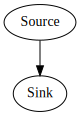

In [115]:
criminal.plot0()

In [113]:
PageRanker.rank(criminal, 10, 0.5)
criminal.showRanking()
criminal.debugRanking()

(0.5, 0.5, )
(0.25, 0.5, )
(0.25, 0.375, )
(0.25, 0.375, )
(0.25, 0.375, )
(0.25, 0.375, )
(0.25, 0.375, )
(0.25, 0.375, )
(0.25, 0.375, )
(0.25, 0.375, )
Source: 0.25
Sink: 0.375
0.625


In [125]:
0.25/0.625

0.4

In [126]:
0.375/0.625

0.6

In [114]:
nx.pagerank(criminal.nxDiGraph(), alpha=0.5, max_iter=10)

{Source: 0.40000009536743164, Sink: 0.5999999046325684}

## Visualization of (small) networks

### With networkx

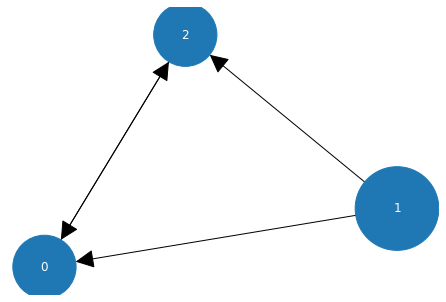

In [16]:
# size based on links
internet.plot1()

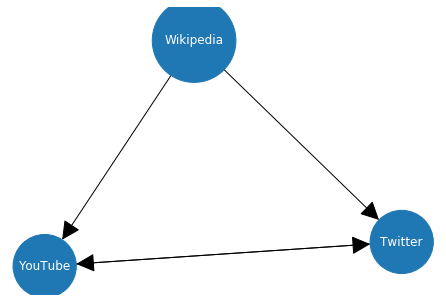

In [17]:
# plot with names (works in this case, but often labels are too large for the nodes)
internet.plot1(names=True)

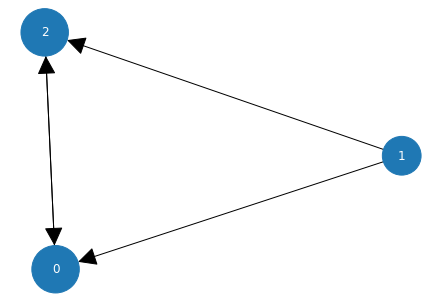

In [18]:
#size based on rank
internet.plot2()

### With graphviz

In [19]:
#internet.plot0()

## Example with anomaly

In [99]:
internetV2= Network()
homepage = Page("Homepage")
for i in range(0,99):
    p = Page("test" + str(i))
    homepage.addLinkTo(p)
    internetV2.addPage(p)
internetV2.addPage(homepage)
PageRanker.rank(internetV2, 1000, 0.5)
internetV2.showRanking()

(0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, )
(0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 0.005050505050505051, 

(0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.0050252525252525255, 0.00502525

In [70]:
internetV2.debugRanking()

0.5025000000000007


In [74]:
total = 0
for page in internetV2:
    total+=page.q
total

1.0000000000000007

In [64]:
print(homepage.outDegree())

99


In [65]:
PageRanker.rank(internetV2, 1000, 0.1)
internetV2.showRanking()

test0: 0.00900909090909091
test1: 0.00900909090909091
test2: 0.00900909090909091
test3: 0.00900909090909091
test4: 0.00900909090909091
test5: 0.00900909090909091
test6: 0.00900909090909091
test7: 0.00900909090909091
test8: 0.00900909090909091
test9: 0.00900909090909091
test10: 0.00900909090909091
test11: 0.00900909090909091
test12: 0.00900909090909091
test13: 0.00900909090909091
test14: 0.00900909090909091
test15: 0.00900909090909091
test16: 0.00900909090909091
test17: 0.00900909090909091
test18: 0.00900909090909091
test19: 0.00900909090909091
test20: 0.00900909090909091
test21: 0.00900909090909091
test22: 0.00900909090909091
test23: 0.00900909090909091
test24: 0.00900909090909091
test25: 0.00900909090909091
test26: 0.00900909090909091
test27: 0.00900909090909091
test28: 0.00900909090909091
test29: 0.00900909090909091
test30: 0.00900909090909091
test31: 0.00900909090909091
test32: 0.00900909090909091
test33: 0.00900909090909091
test34: 0.00900909090909091
test35: 0.00900909090909091
te

In [66]:
internetV2.debugRanking()

0.9008999999999977


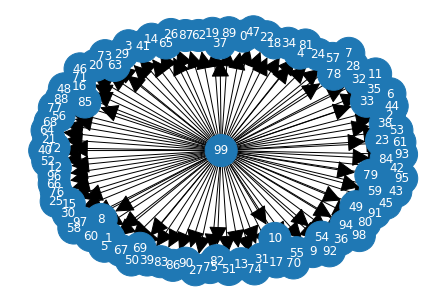

In [24]:
internetV2.plot2()

### Reverse

In [25]:
internetV3= Network()
endpage = Page("Endpage")
for i in range(0,99):
    p = Page("test" + str(i))
    p.addLinkTo(endpage)
    internetV3.addPage(p)
internetV3.addPage(endpage)
PageRanker.rank(internetV3, 1000, 0.5)
internetV3.showRanking()

test0: 0.005
test1: 0.005
test2: 0.005
test3: 0.005
test4: 0.005
test5: 0.005
test6: 0.005
test7: 0.005
test8: 0.005
test9: 0.005
test10: 0.005
test11: 0.005
test12: 0.005
test13: 0.005
test14: 0.005
test15: 0.005
test16: 0.005
test17: 0.005
test18: 0.005
test19: 0.005
test20: 0.005
test21: 0.005
test22: 0.005
test23: 0.005
test24: 0.005
test25: 0.005
test26: 0.005
test27: 0.005
test28: 0.005
test29: 0.005
test30: 0.005
test31: 0.005
test32: 0.005
test33: 0.005
test34: 0.005
test35: 0.005
test36: 0.005
test37: 0.005
test38: 0.005
test39: 0.005
test40: 0.005
test41: 0.005
test42: 0.005
test43: 0.005
test44: 0.005
test45: 0.005
test46: 0.005
test47: 0.005
test48: 0.005
test49: 0.005
test50: 0.005
test51: 0.005
test52: 0.005
test53: 0.005
test54: 0.005
test55: 0.005
test56: 0.005
test57: 0.005
test58: 0.005
test59: 0.005
test60: 0.005
test61: 0.005
test62: 0.005
test63: 0.005
test64: 0.005
test65: 0.005
test66: 0.005
test67: 0.005
test68: 0.005
test69: 0.005
test70: 0.005
test71: 0.005
te

In [26]:
internetV3.debugRanking()

0.9950000000000007


## Statistics

In [27]:
internet.sources()

,Name,Outdegree,Indegree
1,Wikipedia,2,0


In [28]:
internet.sinks()

,Name,Outdegree,Indegree


In [29]:
california.sinks()

,Name,Outdegree,Indegree
9,http://www.leginfo.ca.gov/calaw.html,0,155
13,http://ideas.uqam.ca/ideas/data/fthcalaec.html,0,0
15,http://www.csupomona.edu/,0,36
16,http://www.csuchico.edu/,0,32
33,http://www.ftb.ca.gov/,0,46
...,...,...,...
9655,http://www.fleamarket.net/,0,0
9658,http://remco.com/fun.html,0,0
9660,http://www.maxwellstreet.org/,0,0
9661,http://village.ios.com/~internet/,0,0


In [30]:
california.sources()

,Name,Outdegree,Indegree
7,http://www.tegnetcorporation.com/,11,0
13,http://ideas.uqam.ca/ideas/data/fthcalaec.html,0,0
79,http://www.mapquest.com/wine/mqinterconnect,1,0
95,http://www.angelfire.com/ca/srcom/index.html,4,0
120,http://www.psn.net/support/access_num.phtml,2,0
...,...,...,...
9659,http://www.spd.louisville.edu/~mejenn01/handy....,1,0
9660,http://www.maxwellstreet.org/,0,0
9661,http://village.ios.com/~internet/,0,0
9662,http://www.meats.net/,0,0


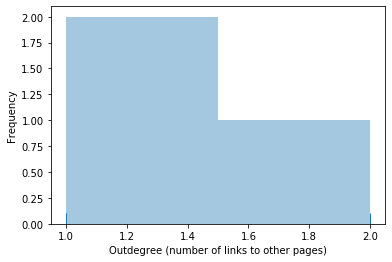

In [31]:
internet.plot_outdegrees()

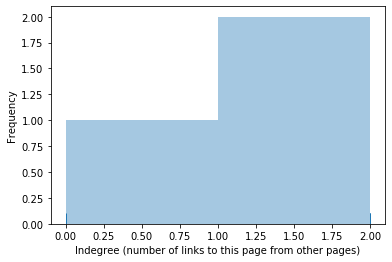

In [32]:
internet.plot_indegrees()

In [33]:
internet.describe()

,Outdegree,Indegree
count,3.000000,3.000000
mean,1.333333,1.333333
std,0.577350,1.154701
min,1.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,1.500000,2.000000
max,2.000000,2.000000


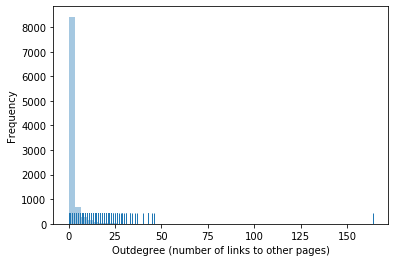

In [34]:
california.plot_outdegrees()

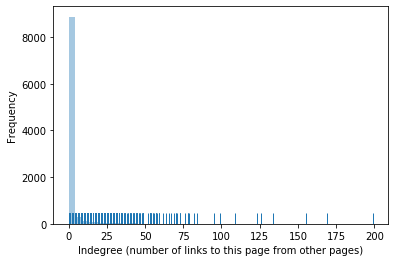

In [35]:
california.plot_indegrees()

In [36]:
california.describe()

,Outdegree,Indegree
count,9664.000000,9664.000000
mean,1.671151,1.671151
std,3.695696,7.457138
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,164.000000,199.000000
